In [2]:
# imports
import databaseUtils as db
import ioFunctions as fnc
import machineLearningUtils as mlu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Jupyter
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
def Xy(df, target):
    return df.loc[:, df.columns!=target], df[target]

def testLR(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=31)
    model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test

def printLR(X, y):
    model, X_train, X_test, y_train, y_test = testLR(X, y)
    mlu.printReport(model, X_train, X_test, y_train, y_test)
    return model

def test(df, target):
    X, y = Xy(df.dropna(), target)
    
    print('===== UNSCALED =====')
    model = printLR(X, y)
    print(model.intercept_, model.coef_)
    
    print('\n===== SCALED =====')
    model = printLR(pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns), y)
    print(model.intercept_, model.coef_)

def testXy(X, y):
    print('===== UNSCALED =====')
    model = printLR(X, y)
    print(model.intercept_, model.coef_)
    
    print('\n===== SCALED =====')
    model = printLR(pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns), y)
    print(model.intercept_, model.coef_)

def extractSelectedColumns(best, X):
    # Extract best k columns
    mask = best.get_support() # for each column, the value is True if k best, False otherwise
    f = [] 
    for is_in_k_best, feature in zip(mask, X.columns):
        if is_in_k_best:
            f.append(feature)

    # Construct a new X
    return pd.DataFrame(X, columns=f)

In [4]:
data = pd.read_csv('../Output/table_total.csv', dtype=np.int32, converters={'counties':str, 'pop':np.int64})
data.head()

,counties,none_care,first_trimester,second_trimester,third_trimester,unknown_care,year,male,female,unknown_gender,...,white_non_hispanic,african_american_non_hispanic,other_non_hispanic,hispanic,gms_0_499,gms_500_1499,gms_1500_2499,gms_2500_8165,unknown_weight,pop
0,ALAMANCE,36,1282,435,87,16,2016,980,876,0,...,1018,398,49,391,6,22,146,1682,0,160283
1,ALEXANDER,9,253,62,19,0,2016,173,170,0,...,296,11,8,28,1,4,28,310,0,37133
2,ALLEGHANY,1,69,16,9,0,2016,50,45,0,...,81,2,0,12,0,0,7,88,0,10919
3,ANSON,5,171,71,18,1,2016,141,125,0,...,110,138,6,12,0,7,22,237,0,25165
4,ASHE,1,167,28,12,1,2016,109,100,0,...,187,2,1,19,1,4,19,185,0,26600


<AxesSubplot:>

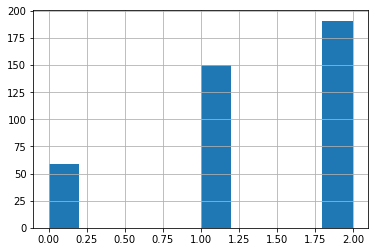

In [21]:
# Creating multiple classes for the pop_cat feature
import random
dataN = data
dataN['pop_cat'] = None
random.seed(3)
for i in range(len(dataN['pop'])):
    if dataN['pop'][i] < dataN['pop'].quantile(random.randint(0,33)/100):
        dataN['pop_cat'][i] = 0
    elif data['pop'][i] < data['pop'].quantile(random.randint(34,67)/100):
        dataN['pop_cat'][i] = 1
    else:
        dataN['pop_cat'][i] = 2
        

dataN['pop_cat'] = dataN['pop_cat'].astype(np.int8)
dataN['pop_cat'].hist()

In [22]:
dataN.head()

,counties,none_care,first_trimester,second_trimester,third_trimester,unknown_care,year,male,female,unknown_gender,...,african_american_non_hispanic,other_non_hispanic,hispanic,gms_0_499,gms_500_1499,gms_1500_2499,gms_2500_8165,unknown_weight,pop,pop_cat
0,ALAMANCE,36,1282,435,87,16,2016,980,876,0,...,398,49,391,6,22,146,1682,0,160283,2
1,ALEXANDER,9,253,62,19,0,2016,173,170,0,...,11,8,28,1,4,28,310,0,37133,1
2,ALLEGHANY,1,69,16,9,0,2016,50,45,0,...,2,0,12,0,0,7,88,0,10919,1
3,ANSON,5,171,71,18,1,2016,141,125,0,...,138,6,12,0,7,22,237,0,25165,0
4,ASHE,1,167,28,12,1,2016,109,100,0,...,2,1,19,1,4,19,185,0,26600,1


In [23]:
X = dataN.drop(['pop_cat', 'counties', 'pop'], axis=1)
y = dataN['pop_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=33)

In [24]:
k=5
from sklearn.model_selection import cross_val_score
scoring = 'accuracy'
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
print('Cross Validation Score Logistic Regression: {:0.2%}'.format(cross_val_score(lr, X_train, y_train, cv=k, scoring=scoring).mean()))

Cross Validation Score Logistic Regression: 78.00%


===== UNSCALED =====
             19        15    13    20        17        14        18        16  \
Score  0.813333  0.813333  0.81  0.81  0.806667  0.806667  0.803333  0.803333   

        12   7   
Score  0.8  0.8  


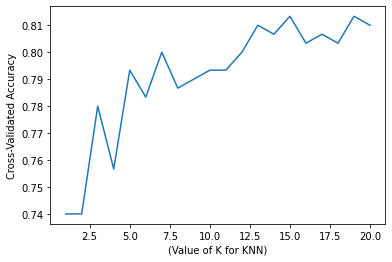

In [25]:
from sklearn.neighbors import KNeighborsClassifier
k_min = 1
k_max = 20
k_range = range(k_min, k_max+1) # [min, max)
k_scores = []
k_scores_scaled = []


for kn in k_range:
    knn = KNeighborsClassifier(n_neighbors=kn)
    scores = cross_val_score(knn, X_train, y_train, cv=k, scoring=scoring)
    k_scores.append(scores.mean())

# Plot
print('===== UNSCALED =====')
plt.plot(k_range, k_scores)
plt.xlabel('(Value of K for KNN)')
plt.ylabel('Cross-Validated Accuracy')

# Find the highest accuracy furthest to the right (larger k ~ reduced complexity)
scores = pd.DataFrame(k_scores, index=pd.RangeIndex(start=k_min, stop=k_max+1, step=1), columns={'Score'}).sort_values(by='Score', ascending=False)
print(scores.head(10).transpose())

In [26]:
knn = KNeighborsClassifier(n_neighbors=15)
print('Cross Validation Score of KNN: {:0.2%}'.format(cross_val_score(knn, X_train, y_train, cv=k, scoring=scoring).mean()))

Cross Validation Score of KNN: 81.33%


Training: 100.00%
Testing:  79.00%


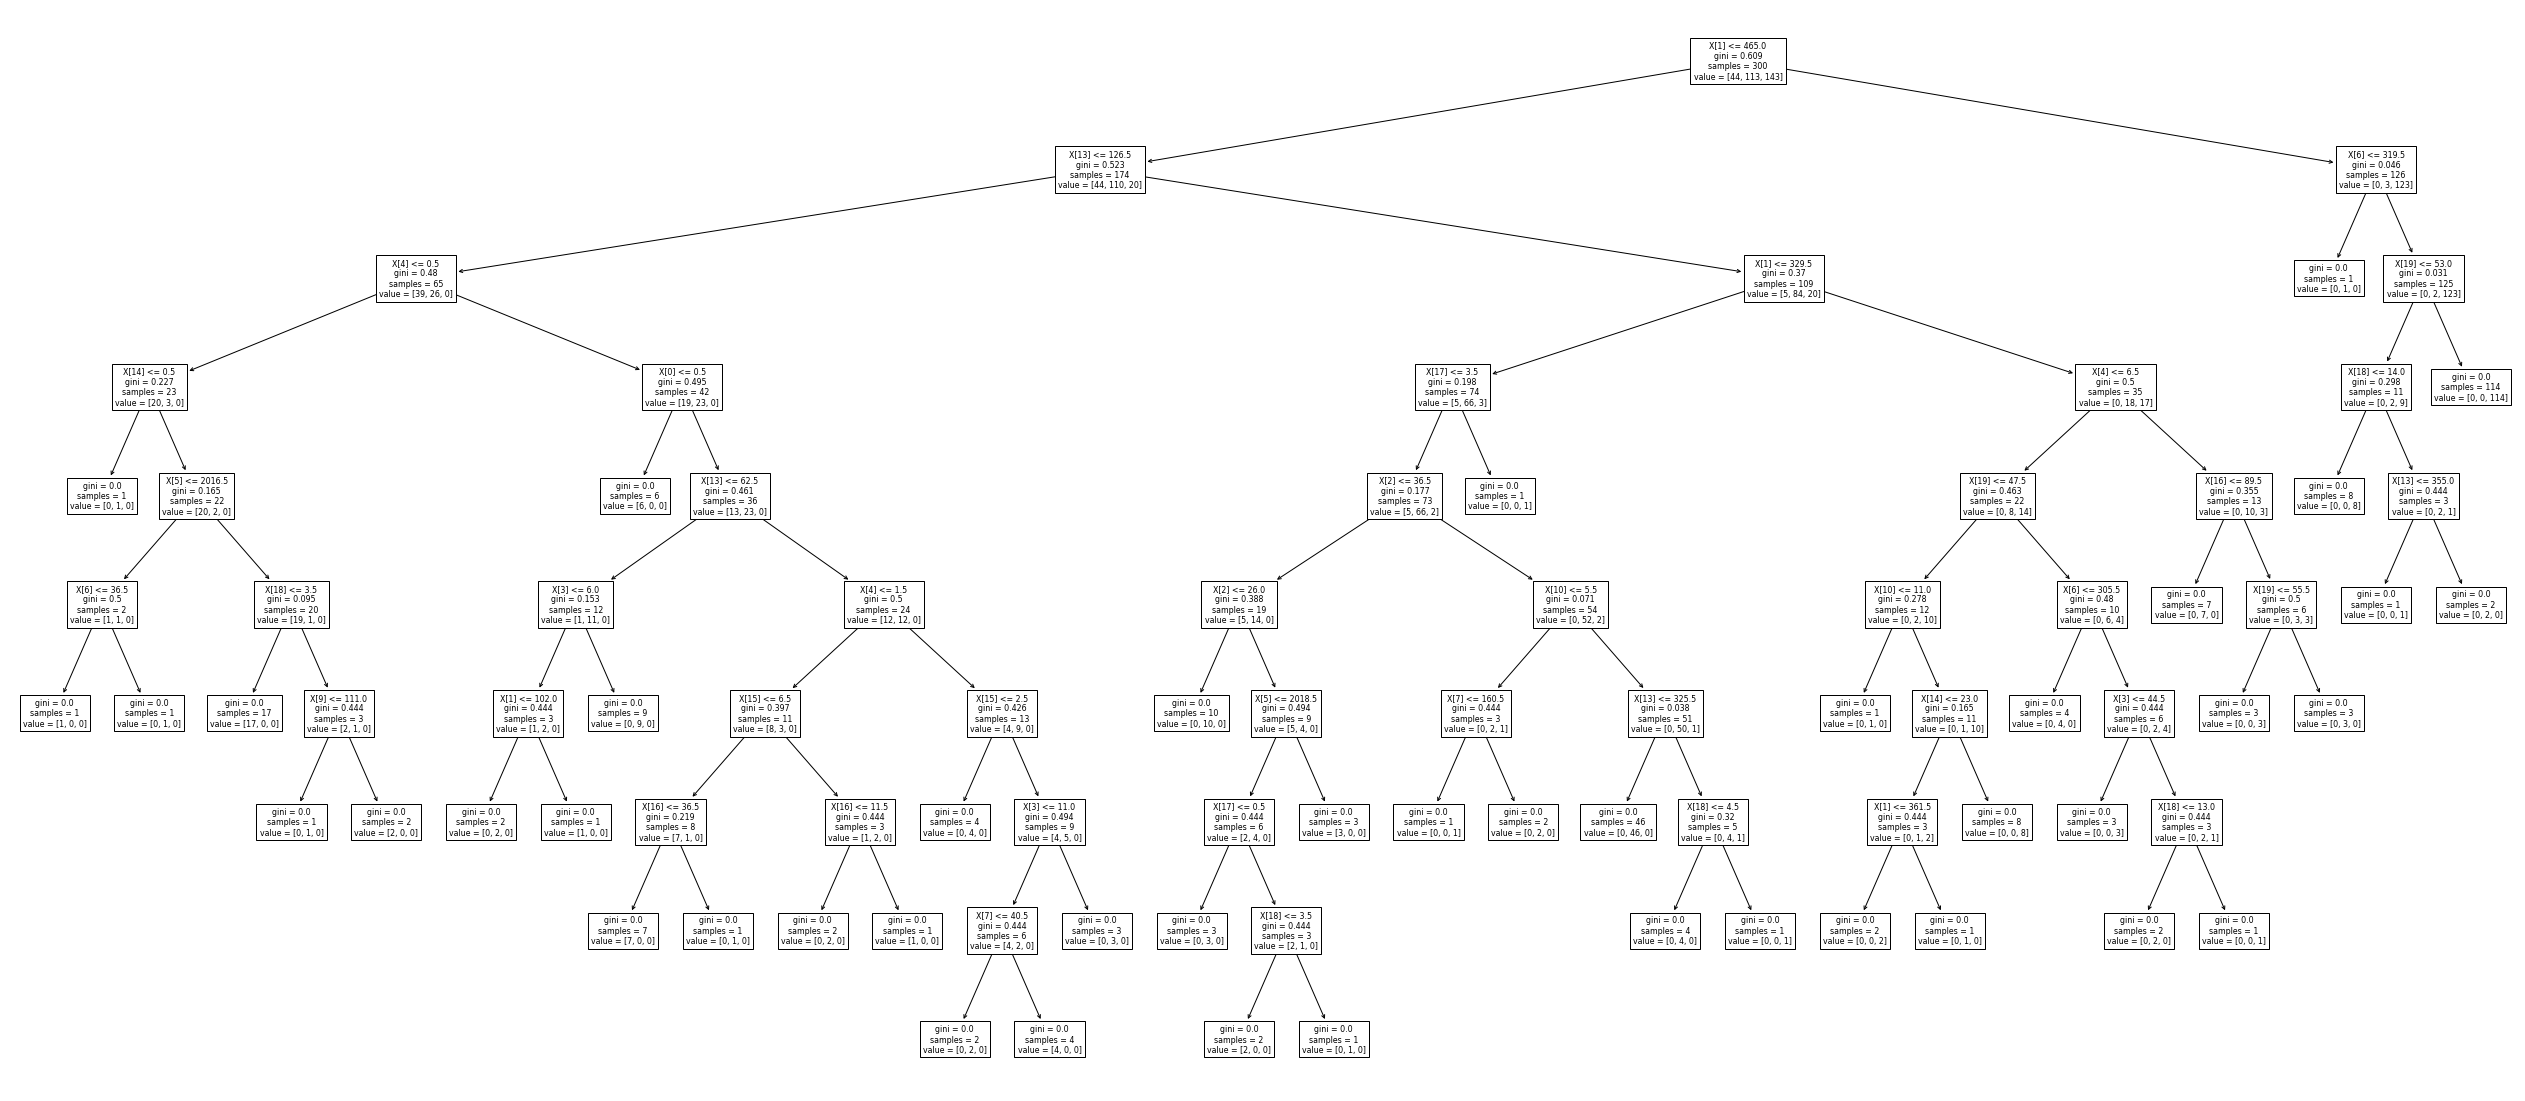

In [28]:
from sklearn.tree import DecisionTreeClassifier 
dt = DecisionTreeClassifier().fit(X_train, y_train)
print(f'Training: {dt.score(X_train, y_train):0.2%}')
print(f'Testing:  {dt.score(X_test, y_test):0.2%}')

from sklearn import tree 
plt.figure(figsize=(45,20))
tree.plot_tree(dt)
plt.savefig('../Output/NBdecisionTree.png')

In [29]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, y_train)
print('Random Forest Report')
print(f'Training: {rf.score(X_train, y_train):0.2%}')
print(f'Testing:  {rf.score(X_test, y_test):0.2%}')

Random Forest Report
Training: 100.00%
Testing:  84.00%


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
param_grid = {
      'hidden_layer_sizes': [50, 100, 150]      # default is 100
    , 'activation': ['logistic', 'relu']        # default is relu
    , 'learning_rate': ['constant', 'adaptive'] # default is constant
}

# Grid search
model = GridSearchCV(MLPClassifier(), param_grid, cv=k).fit(X_train, y_train)

# Best params
print(model.best_params_)

# Model with best params
print(f'Training: {model.best_estimator_.score(X_train, y_train):0.2%}')
print(f'Testing:  {model.best_estimator_.score(X_test, y_test):0.2%}')

{'activation': 'logistic', 'hidden_layer_sizes': 100, 'learning_rate': 'constant'}
Training: 87.00%
Testing:  86.00%


# Scaling

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [32]:
k=5
from sklearn.model_selection import cross_val_score
scoring = 'accuracy'
lr = LogisticRegression(solver='liblinear').fit(X_train_scaled, y_train)
print('Cross Validation Score Logistic Regression: {:0.2%}'.format(cross_val_score(lr, X_train_scaled, y_train, cv=k, scoring=scoring).mean()))

Cross Validation Score Logistic Regression: 76.33%


===== SCALED =====
             5         6     9     4     7         10        8         13  \
Score  0.753333  0.753333  0.74  0.74  0.74  0.736667  0.736667  0.733333   

         3         17  
Score  0.73  0.726667  


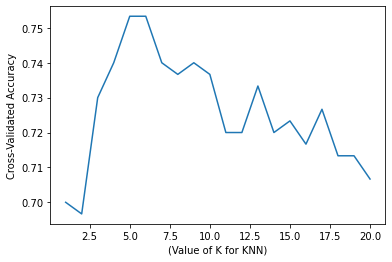

In [33]:
k_scores = []

for kn in k_range:
    knn = KNeighborsClassifier(n_neighbors=kn)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=k, scoring=scoring)
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('(Value of K for KNN)')
plt.ylabel('Cross-Validated Accuracy')

scores = pd.DataFrame(k_scores, index=pd.RangeIndex(start=k_min, stop=k_max+1, step=1), columns={'Score'}).sort_values(by='Score', ascending=False)
print(scores.head(10).transpose())

In [34]:
optimal_k = 7
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)
print('Report for KNN')
print(f'Training: {knn.score(X_train_scaled, y_train):0.2%}')
print(f'Testing:  {knn.score(X_test_scaled, y_test):0.2%}')

Report for KNN
Training: 83.00%
Testing:  80.00%


Training: 100.00%
Testing:  81.00%


[Text(0.6904481132075472, 0.9545454545454546, 'X[1] <= -0.241\ngini = 0.609\nsamples = 300\nvalue = [44, 113, 143]'),
 Text(0.4375, 0.8636363636363636, 'X[13] <= -0.522\ngini = 0.523\nsamples = 174\nvalue = [44, 110, 20]'),
 Text(0.16745283018867924, 0.7727272727272727, 'X[4] <= -0.484\ngini = 0.48\nsamples = 65\nvalue = [39, 26, 0]'),
 Text(0.05660377358490566, 0.6818181818181818, 'X[14] <= -0.439\ngini = 0.227\nsamples = 23\nvalue = [20, 3, 0]'),
 Text(0.03773584905660377, 0.5909090909090909, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.07547169811320754, 0.5909090909090909, 'X[5] <= -0.91\ngini = 0.165\nsamples = 22\nvalue = [20, 2, 0]'),
 Text(0.03773584905660377, 0.5, 'X[3] <= -0.414\ngini = 0.5\nsamples = 2\nvalue = [1, 1, 0]'),
 Text(0.018867924528301886, 0.4090909090909091, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(0.05660377358490566, 0.4090909090909091, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]'),
 Text(0.11320754716981132, 0.5, 'X[18] <= -0.445\ngini =

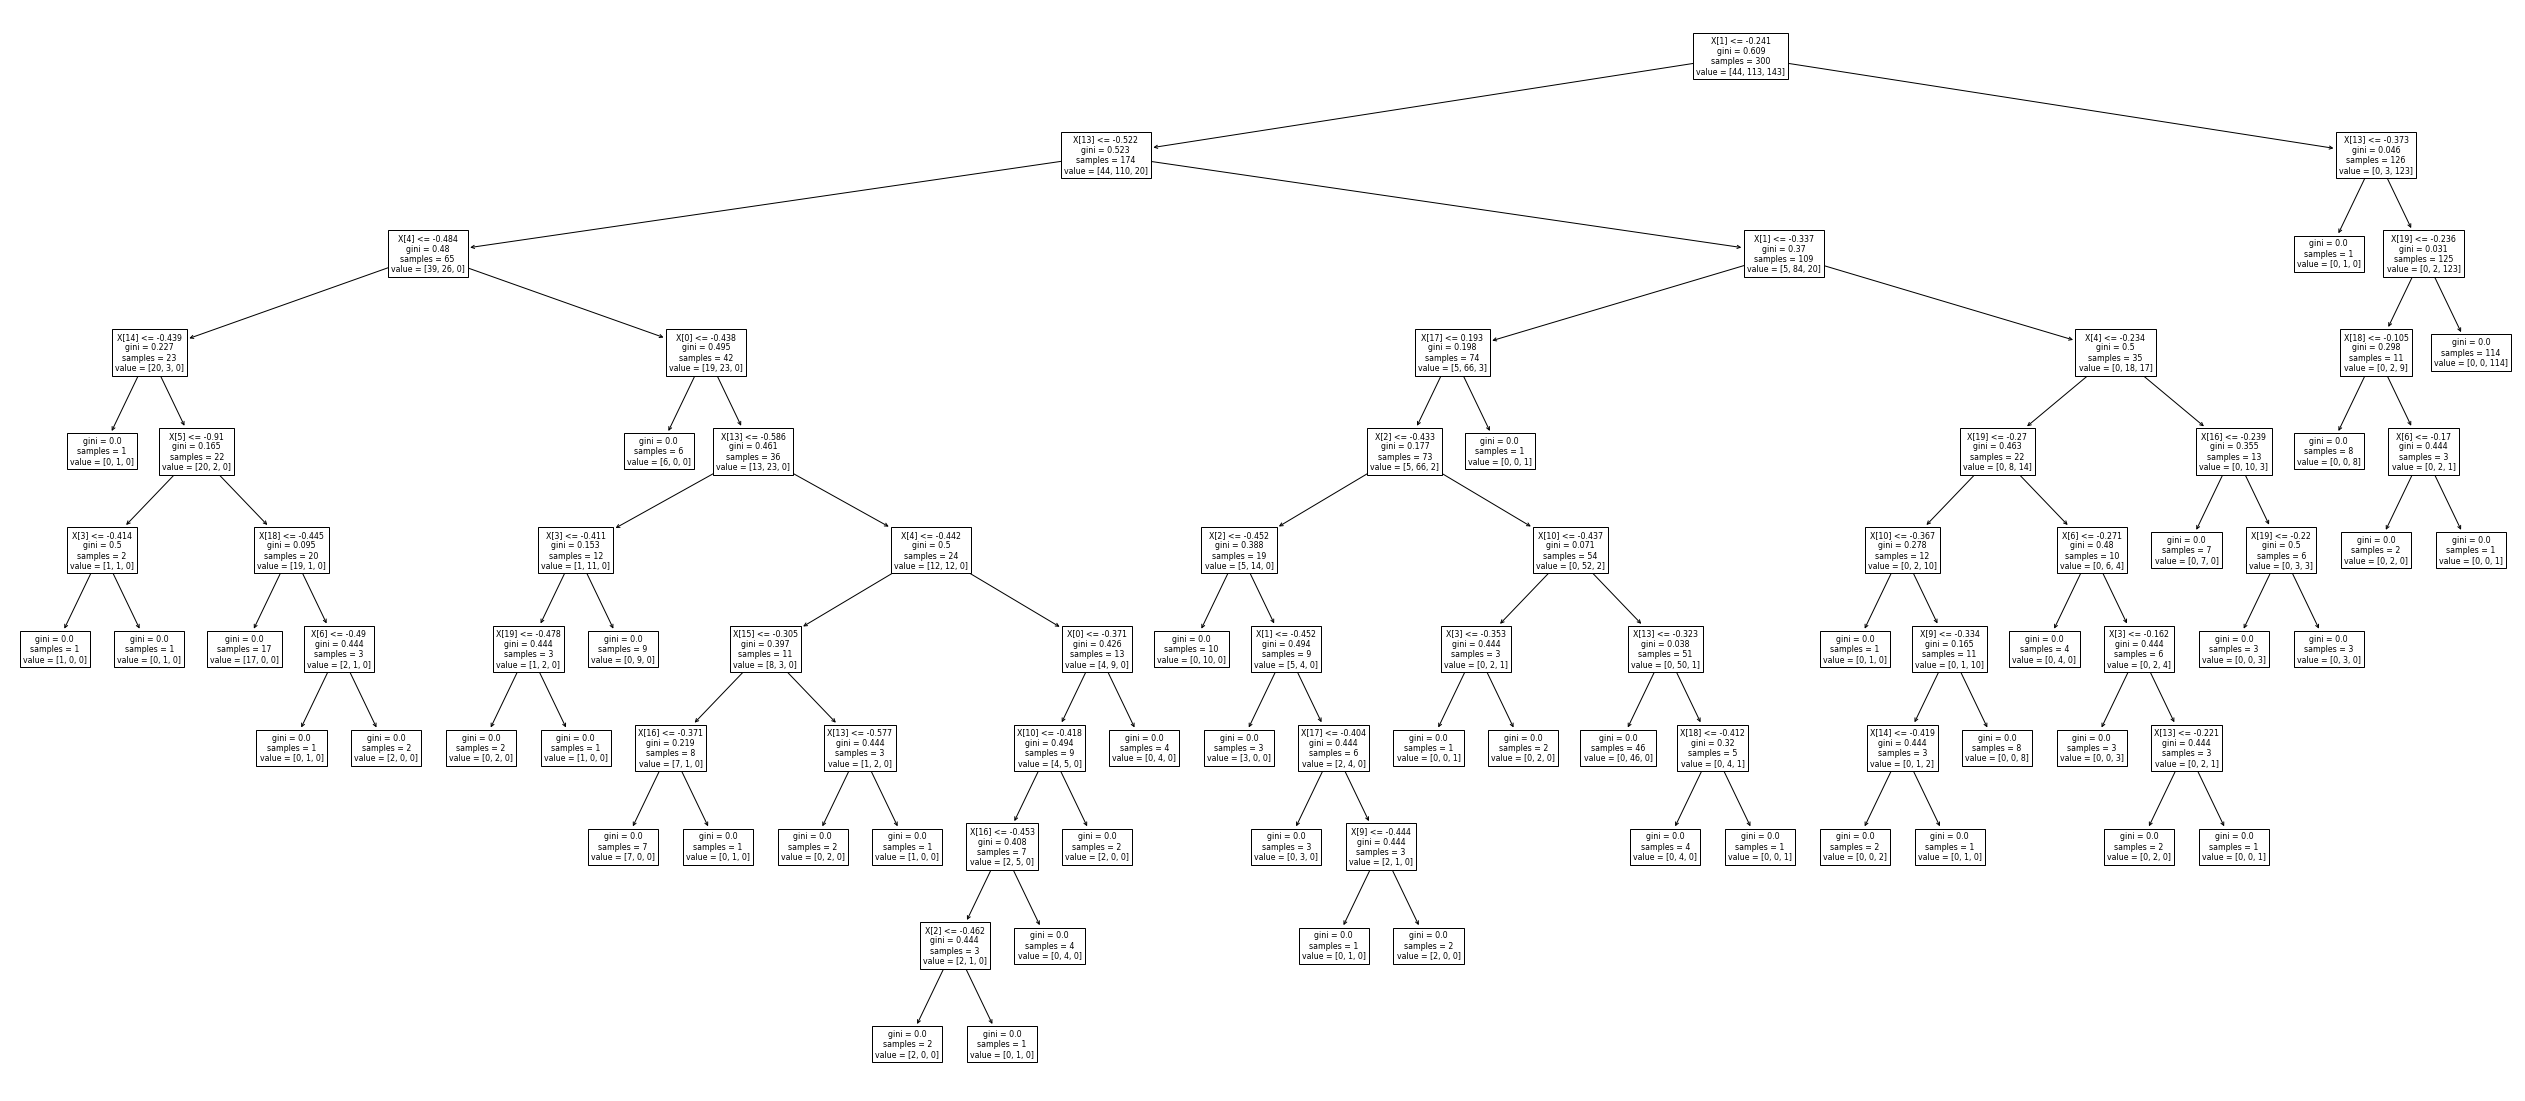

In [38]:
dt = DecisionTreeClassifier().fit(X_train_scaled, y_train)
print(f'Training: {dt.score(X_train_scaled, y_train):0.2%}')
print(f'Testing:  {dt.score(X_test_scaled, y_test):0.2%}')

from sklearn import tree 
plt.figure(figsize=(45,20))
tree.plot_tree(dt)

In [36]:
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
print('Random Forest Report')
print(f'Training: {rf.score(X_train_scaled, y_train):0.2%}')
print(f'Testing:  {rf.score(X_test_scaled, y_test):0.2%}')

Random Forest Report
Training: 100.00%
Testing:  83.00%


In [37]:
model = GridSearchCV(MLPClassifier(), param_grid, cv=k).fit(X_train_scaled, y_train)

# Best params
print(model.best_params_)

# Model with best params
#mlu.printCrossValidationResults(model.best_estimator_, X_test, y_test, k)
print(f'Training: {model.best_estimator_.score(X_train_scaled, y_train):0.2%}')
print(f'Testing:  {model.best_estimator_.score(X_test_scaled, y_test):0.2%}')

{'activation': 'relu', 'hidden_layer_sizes': 150, 'learning_rate': 'constant'}
Training: 84.67%
Testing:  81.00%
